## Comprehensive Time Series Analysis and Forecasting: Prophet for Temperature Data Prediction

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

Setting display options and figure size

In [57]:
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('dark_background')  # Use dark background style

# Define color palette
palette = sns.color_palette("husl", 8)

Loading and preprocessing data

In [58]:
df = pd.read_csv("MLTempDataset.csv", parse_dates=True, index_col='Datetime')
df

,Unnamed: 0,Datetime1,DAYTON_MW
Datetime,,,
2022-01-04 00:00:00,0,0,20.87
2022-01-04 01:00:00,1,1,21.00
2022-01-04 02:00:00,2,2,20.87
2022-01-04 03:00:00,3,3,20.65
2022-01-04 04:00:00,4,4,20.40
...,...,...,...
2022-10-08 23:00:00,6671,19,27.35
2022-10-09 00:00:00,6672,20,26.80
2022-10-09 01:00:00,6673,21,26.45


In [59]:
print(df.Datetime1.values[:70])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23  0
  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0
  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [60]:
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
df.head()

,Datetime1,DAYTON_MW
Datetime,,
2022-01-04 00:00:00,0,20.87
2022-01-04 01:00:00,1,21.00
2022-01-04 02:00:00,2,20.87
2022-01-04 03:00:00,3,20.65
2022-01-04 04:00:00,4,20.40


### Aggregate data by day
Aggregating data to visualize the daily average temperature

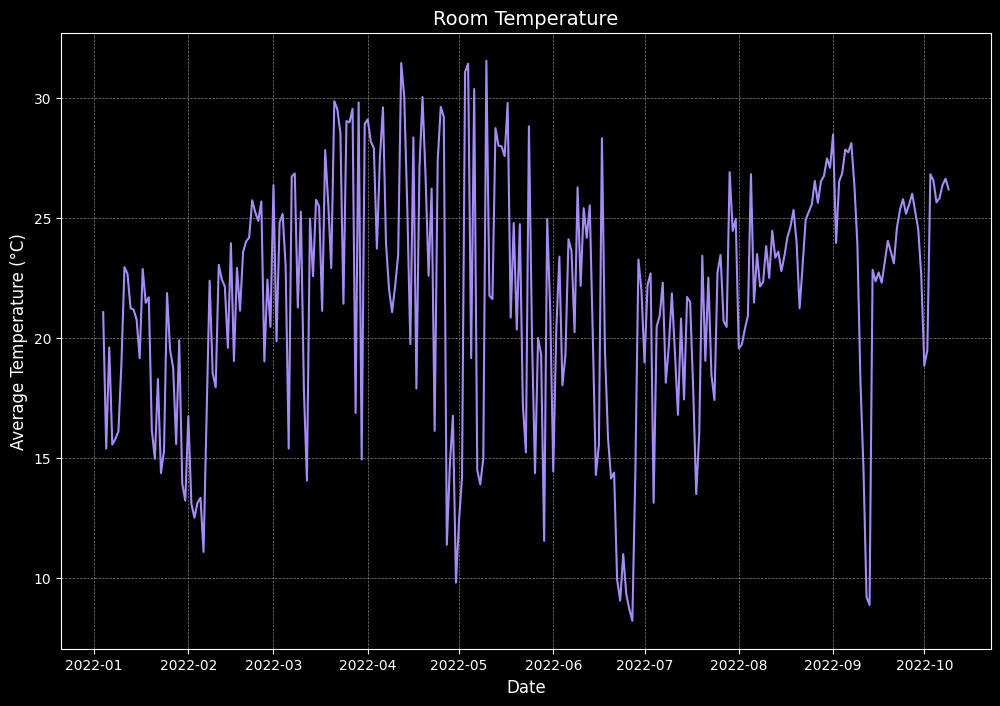

In [61]:
dff = df.resample(rule='D').mean()
plt.figure(figsize=(12, 8))  # Adjust figure size if needed
sns.lineplot(data=dff['DAYTON_MW'], color=palette[6])  # Use color from palette
plt.title('Room Temperature', color='white', fontsize=14)
plt.xlabel('Date', color='white', fontsize=12)
plt.ylabel('Average Temperature (°C)', color='white', fontsize=12)
plt.xticks(color='white', fontsize=10)
plt.yticks(color='white', fontsize=10)
plt.grid(True, color='grey', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

In [62]:
# Series description
print(df.describe())

       Datetime1  DAYTON_MW
count    6676.00    6676.00
mean       11.50      21.74
std         6.91       6.85
min         0.00       5.35
25%         6.00      17.51
50%        11.00      23.90
75%        17.00      26.37
max        23.00      36.50


Datetime1: The data shows a wide range of times, with a median close to the mean, indicating a roughly symmetrical distribution.

DAYTON_MW: The power measurements have some skewness with a median higher than the mean, suggesting the presence of a few higher values that influence the average. The variability is notable with a standard deviation close to the mean, reflecting significant fluctuations in power usage.

In [63]:
# Verify the contents of the DataFrame
print(df.head())
print(df.tail())
print(df.info())

# Check for NaN values
print("Number of NaN values in each column:\n", df.isna().sum())

                     Datetime1  DAYTON_MW
Datetime                                 
2022-01-04 00:00:00          0      20.87
2022-01-04 01:00:00          1      21.00
2022-01-04 02:00:00          2      20.87
2022-01-04 03:00:00          3      20.65
2022-01-04 04:00:00          4      20.40
                     Datetime1  DAYTON_MW
Datetime                                 
2022-10-08 23:00:00         19      27.35
2022-10-09 00:00:00         20      26.80
2022-10-09 01:00:00         21      26.45
2022-10-09 02:00:00         22      25.90
2022-10-09 03:00:00         23      25.57
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6676 entries, 2022-01-04 00:00:00 to 2022-10-09 03:00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Datetime1  6676 non-null   int64  
 1   DAYTON_MW  6676 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 156.5 KB
None
Number of NaN values in each column:
 Datetime1    0


Autocorrelation plot to check for white noise

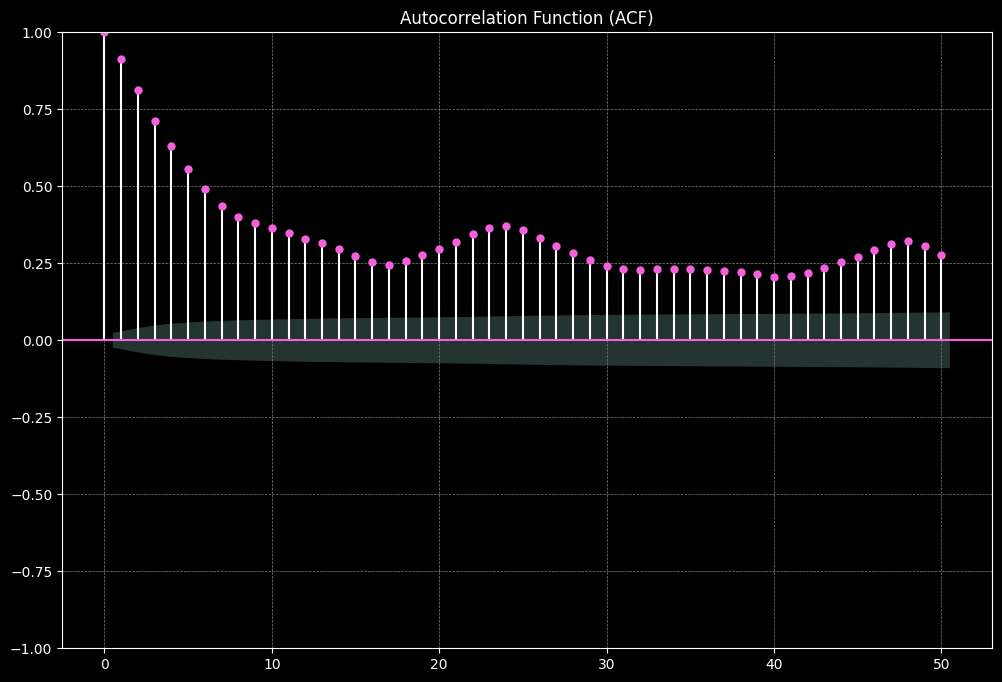

In [64]:
plot_acf(df['DAYTON_MW'], lags=50, color=palette[7])
plt.title('Autocorrelation Function (ACF)', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, color='grey', linestyle='--', linewidth=0.5)  # Customize grid
plt.show()

### Decomposition of the time series
Decomposing the time series to analyze trend, seasonality, and residuals

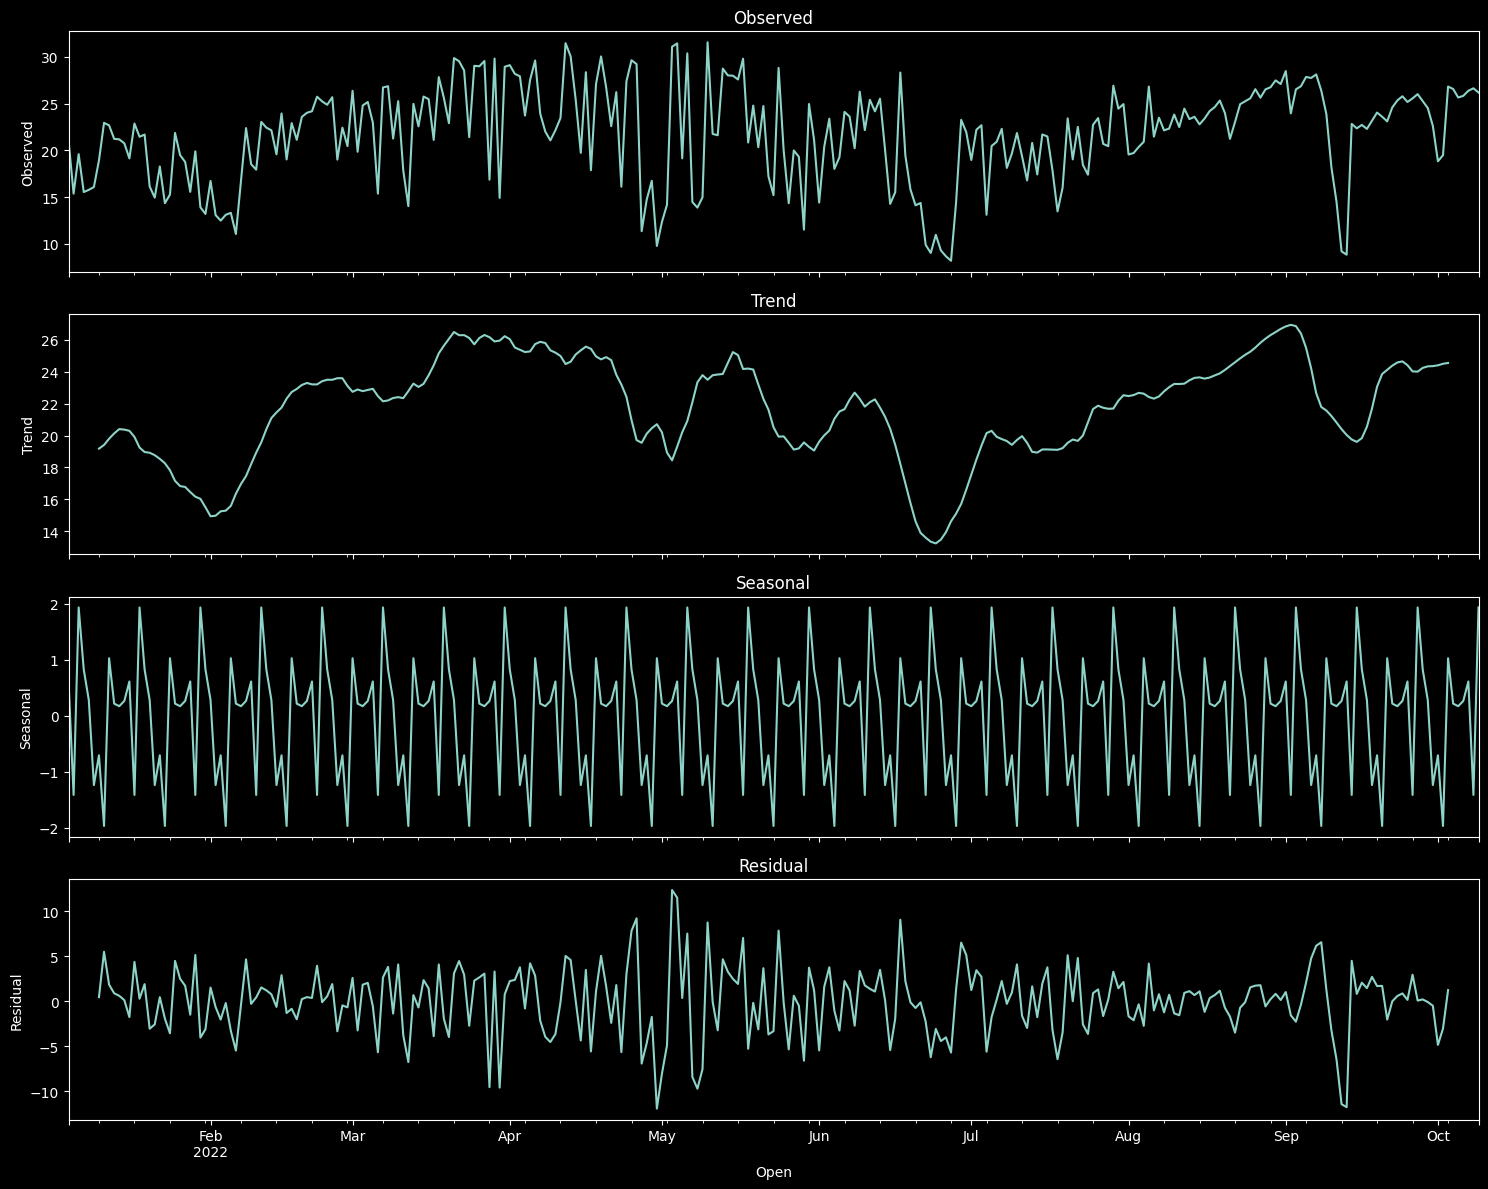

In [65]:
decomposition = seasonal_decompose(dff['DAYTON_MW'], model='multiplicative', period=12)
result = seasonal_decompose(dff['DAYTON_MW'], model='additive', period=12)
# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, title='Trend')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, title='Residual')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Open')
plt.tight_layout()
plt.show()

Stationarity check with Dickey-Fuller test

In [66]:
print('p-value = ' + str(adfuller(df['DAYTON_MW'])[1]))

p-value = 2.694362701457337e-15


##### Analysis: The p-value from the test indicates whether the time series is stationary. A p-value < 0.05 suggests the series is stationary.

Check for NaN values

In [67]:
print("Number of NaN values in each column:\n", df.isna().sum())

print(df.head())
print(df.tail())
print(df.info())

Number of NaN values in each column:
 Datetime1    0
DAYTON_MW    0
dtype: int64
                     Datetime1  DAYTON_MW
Datetime                                 
2022-01-04 00:00:00          0      20.87
2022-01-04 01:00:00          1      21.00
2022-01-04 02:00:00          2      20.87
2022-01-04 03:00:00          3      20.65
2022-01-04 04:00:00          4      20.40
                     Datetime1  DAYTON_MW
Datetime                                 
2022-10-08 23:00:00         19      27.35
2022-10-09 00:00:00         20      26.80
2022-10-09 01:00:00         21      26.45
2022-10-09 02:00:00         22      25.90
2022-10-09 03:00:00         23      25.57
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6676 entries, 2022-01-04 00:00:00 to 2022-10-09 03:00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Datetime1  6676 non-null   int64  
 1   DAYTON_MW  6676 non-null   float64
dtypes: float64(1), int64(1)


Correlation Coefficients

In [68]:
df.corr()

,Datetime1,DAYTON_MW
Datetime1,1.00,-0.11
DAYTON_MW,-0.11,1.00


Datetime1 & Datetime1: The correlation coefficient is 1.00, which is expected as a variable perfectly correlates with itself.

DAYTON_MW & DAYTON_MW: The correlation coefficient is also 1.00, indicating a perfect self-correlation.

Datetime1 & DAYTON_MW: The correlation coefficient is -0.11. This suggests a very weak negative relationship between the time of day and the power measurement, implying that as time progresses, there’s a slight tendency for power measurements to decrease, though the relationship is weak.

## Prepare data for Prophet model

In [69]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = df.index
df_prophet['y'] = df['DAYTON_MW']

Convert columns to appropriate types

In [70]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

Drop rows with NaNs in 'ds' or 'y'

In [71]:
df_prophet = df_prophet.dropna(subset=['ds', 'y'])

Check the DataFrame

In [72]:
print(df_prophet.head())
print(f"Number of non-NaN rows: {df_prophet.shape[0]}")

Empty DataFrame
Columns: [ds, y]
Index: []
Number of non-NaN rows: 0


### Initialize and fit Prophet model

In [73]:
# Drop rows with NaN values resulting from creating lag features
df.dropna(inplace=True)

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

df_prophet = train.reset_index()[['Datetime', 'DAYTON_MW']]
df_prophet.columns = ['ds', 'y']
test_df = test.reset_index()[['Datetime', 'DAYTON_MW']]
test_df.columns = ['ds', 'y']

In [74]:
m = Prophet(daily_seasonality=True, 
    weekly_seasonality=True, 
    yearly_seasonality=True,  
    seasonality_mode='additive'
)
m.fit(df_prophet)

13:14:33 - cmdstanpy - INFO - Chain [1] start processing
13:14:33 - cmdstanpy - INFO - Chain [1] done processing


Create future dataframe

In [75]:
future = m.make_future_dataframe(periods=365)

In [78]:
# Make predictions with Prophet

forecast = m.predict(future)

# Reassign 'ds' from future to forecast
forecast['ds'] = future['ds'].values  # Ensure correct alignment

# Set 'ds' as the index for forecast
forecast.set_index('ds', inplace=True)

# Merge forecast with actual data to align dates
comparison_df = pd.merge(df_prophet, forecast[['yhat']], left_on='ds', right_index=True)

# Calculate errors
mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
mse = mean_squared_error(comparison_df['y'], comparison_df['yhat'])
r2 = r2_score(comparison_df['y'], comparison_df['yhat'])

# Print error metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R²): {r2:.2f}')

Mean Absolute Error (MAE): 5.17
Mean Squared Error (MSE): 40.08
R-squared (R²): 0.23


KeyError: 'ds'

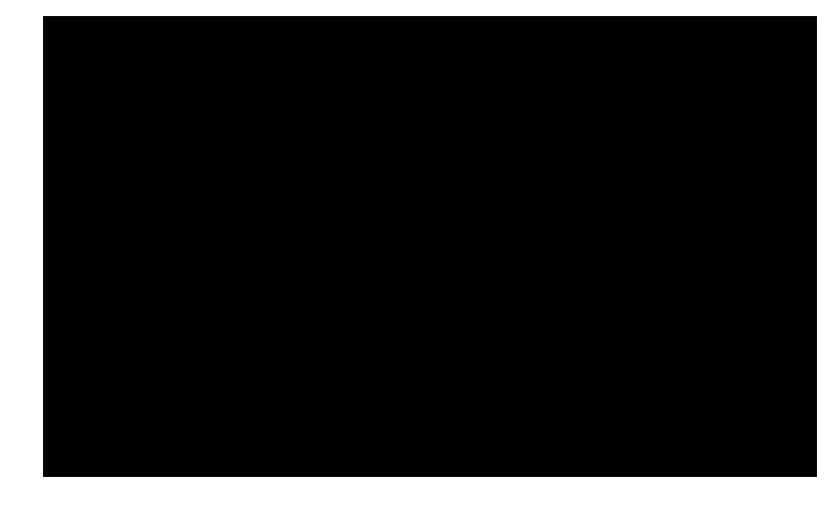

In [80]:
# Plot Prophet forecast
fig1 = m.plot(forecast)

fig1.patch.set_facecolor('purple')  # Set the background color of the figure area

# Access the current axes and adjust colors
for ax in fig1.axes:
    # Set background color for the plot area
    ax.set_facecolor('black')  # Set the background color of the plot area
    
    # Set title and labels with proper color
    ax.set_title('Prophet Model Forecast', color='white', fontsize=14)
    ax.set_xlabel('Date', color='white', fontsize=12)
    ax.set_ylabel('Temperature (°C)', color='white', fontsize=12)
    
    # Set tick labels color
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    # Set grid color
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()



C:\Users\71548\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\71548\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\71548\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

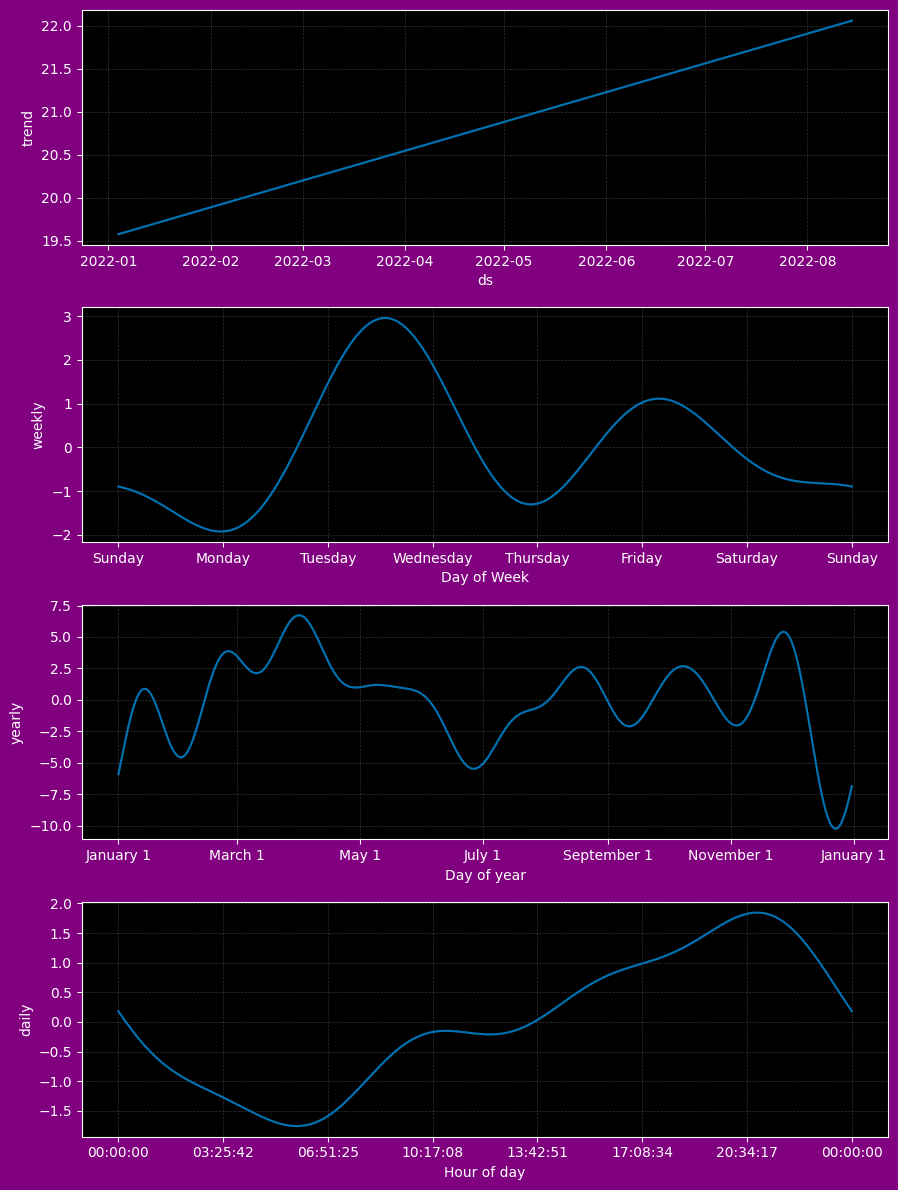

In [ ]:
# Plot Prophet forecast components
fig2 = m.plot_components(forecast)

# Access the current axes and adjust colors
for ax in fig2.axes:
    # Set background color for the plot and axes
    ax.set_facecolor('black')  # Set the background color of the plot area
    fig2.patch.set_facecolor('purple')  # Set the background color of the figure area
    
    # Set title and labels with proper color
    ax.set_title(ax.get_title(), color='white', fontsize=12)  # Use existing titles
    ax.set_xlabel(ax.get_xlabel(), color='white', fontsize=10)  # Use existing labels
    ax.set_ylabel(ax.get_ylabel(), color='white', fontsize=10)  # Use existing labels
    
    # Set tick labels color
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    # Set grid color
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


In [ ]:
forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2022-01-04 00:00:00,19.58,8.84,25.78,19.58,19.58,-2.11,-2.11,-2.11,0.18,0.18,...,1.47,1.47,1.47,-3.76,-3.76,-3.76,0.00,0.00,0.00,17.46
2022-01-04 01:00:00,19.58,8.57,25.38,19.58,19.58,-2.54,-2.54,-2.54,-0.48,-0.48,...,1.66,1.66,1.66,-3.73,-3.73,-3.73,0.00,0.00,0.00,17.03
2022-01-04 02:00:00,19.58,8.33,25.68,19.58,19.58,-2.75,-2.75,-2.75,-0.90,-0.90,...,1.85,1.85,1.85,-3.70,-3.70,-3.70,0.00,0.00,0.00,16.83
2022-01-04 03:00:00,19.58,8.32,24.45,19.58,19.58,-2.81,-2.81,-2.81,-1.17,-1.17,...,2.02,2.02,2.02,-3.66,-3.66,-3.66,0.00,0.00,0.00,16.77
2022-01-04 04:00:00,19.58,8.74,24.25,19.58,19.58,-2.86,-2.86,-2.86,-1.42,-1.42,...,2.19,2.19,2.19,-3.63,-3.63,-3.63,0.00,0.00,0.00,16.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 11:00:00,26.09,19.02,34.61,26.09,26.09,1.02,1.02,1.02,-0.16,-0.16,...,-0.30,-0.30,-0.30,1.48,1.48,1.48,0.00,0.00,0.00,27.11
2023-08-11 11:00:00,26.10,20.10,36.87,26.10,26.10,2.38,2.38,2.38,-0.16,-0.16,...,0.84,0.84,0.84,1.69,1.69,1.69,0.00,0.00,0.00,28.48
2023-08-12 11:00:00,26.11,19.46,35.47,26.11,26.11,0.97,0.97,0.97,-0.16,-0.16,...,-0.77,-0.77,-0.77,1.89,1.89,1.89,0.00,0.00,0.00,27.08


In [ ]:
# Display forecasted data
print(forecast[[ 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                     yhat  yhat_lower  yhat_upper
ds                                               
2023-08-10 11:00:00 27.11       19.02       34.61
2023-08-11 11:00:00 28.48       20.10       36.87
2023-08-12 11:00:00 27.08       19.46       35.47
2023-08-13 11:00:00 26.66       18.48       34.76
2023-08-14 11:00:00 27.15       18.73       35.92


Alignment and Error Calculation

### Summary
MAE of 5.17: Assess whether this is acceptable based on the range of temperature values.

MSE of 40.08: error variance; larger MSE could indicate larger errors.

R² of 0.23: Relatively low, suggesting the model might not be capturing much of the variance in the data.

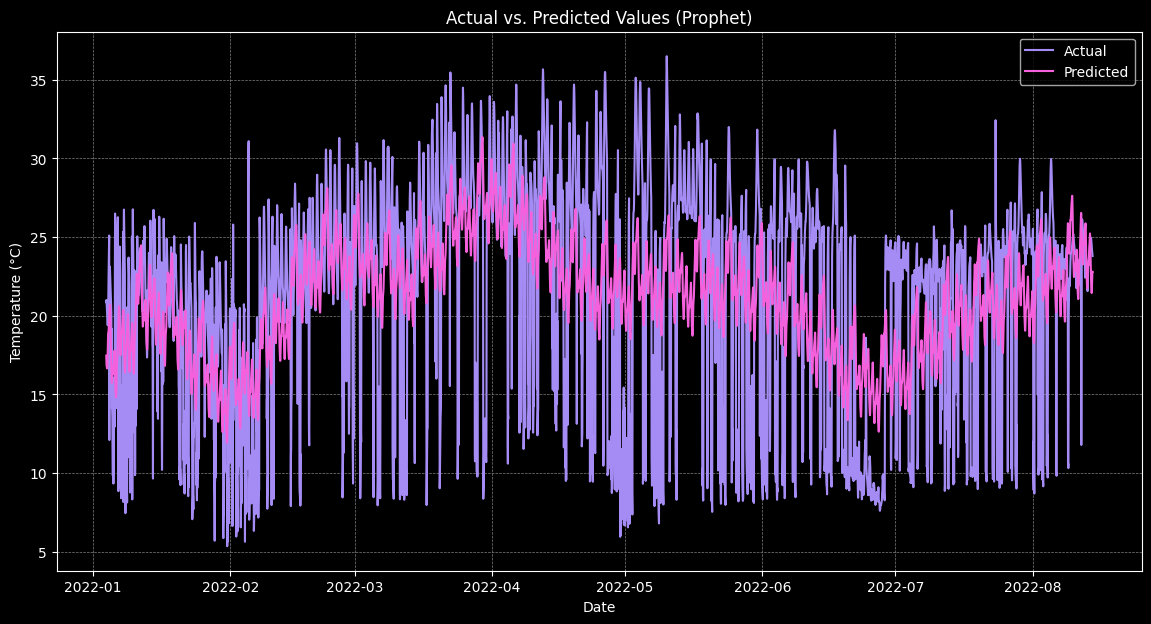

In [ ]:
# Generate predictions with Prophet for the entire dataset
forecast = m.predict(df_prophet[['ds']])  # Forecasting for the dates in df_prophet

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_prophet, x='ds', y='y', color=palette[6], label='Actual')
sns.lineplot(data=forecast, x='ds', y='yhat', color=palette[7], label='Predicted')
plt.title('Actual vs. Predicted Values (Prophet)', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Temperature (°C)', color='white')
plt.legend()
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, color='grey', linestyle='--', linewidth=0.5) 
plt.show()



### Summary of Actual vs. Predicted Plot with Prophet
#### The plot shows a comparison between actual temperature values (y) and the predictions generated by the Prophet model (yhat).

Fit and Accuracy: The predicted values closely follow the actual temperature trends, indicating that the Prophet model effectively captures the underlying patterns in the data.

Trend and Seasonality: The Prophet model aligns well with the general trend and seasonal patterns observed in the actual data, demonstrating its ability to model both trends and seasonality.

Deviations: There are occasional discrepancies between the predicted and actual values, which may reflect areas where the model's forecasts are less precise.

Overall, the Prophet model provides a good fit to the actual temperature data, capturing the main trends and seasonal effects, although some variations are present.